# Chapter 15: Processing Sequences Using RNNs and CNNs
This work is partialy combined text and code from the book [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) and is only supposed to be used as reference and recommended to follow along with a copy of the Book puchased. 

In [1]:
import tensorflow as tf
from tensorflow import keras 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme()

This chapter we will discuss recurrent neural networks (RNNs), a class of nets that can work on sequences of arbitrary lenghts, rather than on fixed-sized inputs.

After that we'll see two main difficulties that RNNs face:
- Unstable gradients and and techniques to resolve it
- A (very) limited short-term memory, which can be extended using LSTM and GRU cells.

And we'll end the chapter by implementing *WaveNet*.

# Recurrent Neurons and Layers
<mark>A recurrent neural network looks very much like a feedforward neural network, except is also has connections pointing backward.</mark>

At each *time step* $t$ (also called a *frame*), this *recurrent neuron* receives the inputs $x_{(i)}$ as well as its own output from the previous time step, $y_{(i-1)}$. Since there is no previous output at the first time step, it is generally set to 0. 

We can represent a tiny network against time, this is referred to as *unrolling network through time*.



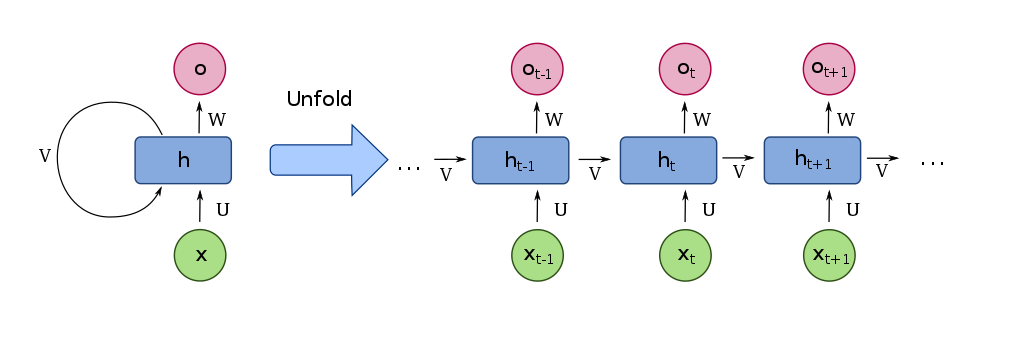

We can easily stack such neurons in a layer, which will recieve input vector $x_{(t)}$ and the output vector from the previous time step $y_{(t-1)}$.

Each recurrent neuron has two sets of weights:
- $w_x$ for the inputs
- $y{(t-1)}$ for the outputs of the previous time step.

If we consider the whole layer, then we're going to have $W_x$ and $W_y$.

*Equation 15-1. Ouput of a recurrent layer for a single instance*
$$y_{(y)}=\phi\big(W_x^\top x_{(t)}+W_y^\top y_{(y-1)} + b\big)$$

<mark>*Equation 15-2. Ouptuts of a layer of recurrent neurons for all instances in a mini-batch*
$$\begin{equation}\begin{split}Y_{(t)}&= \phi\big(X_{(t)}W_x + Y_{(t-1)}W_y+b \big)\\&=\phi\big(\big[X_{(t)}\quad Y_{(t-1)}\big]W+b\big)\text{   with     } W=\begin{bmatrix}W_x\\W_y\end{bmatrix}\end{split}\end{equation}	
$$</mark>

In this equation:
- $Y_{(t)}$ is a $m\times n_\text{neurons}$ matrix containing the layer's outputs at time step $t$.
- $X_{(t)}$ is an $m\times n_\text{inputs}$ matrix containing the inputs for all the instances.
- $W_x$ is an $n_\text{inputs}\times n_\text{neurons}$ matrix containing the connection weights for the inputs of the current time step.
- $W_y$ is an $n_\text{neurons}\times n_\text{neurons}$ matrix containing the connection weights for the outputs of the previous time step.
- $b$ is a vector of size $n_\text{neurons}$ containing each neuron's bias term.

**$Y_{(t)}$ is a function of all the inputs since time $t=0$**




## Memory Cells
<mark>A part of neural network that preserves some state across time steps is calles a *memory cell*.</mark>

Since the output of a recurrent neuron at time step $t$ is a function of all the inputs from previous time steps, we cam say it has a form of *memory*.

- <mark>In general a cell's state at time step $t$, denoted $h_{(t)}$ (the "h" denotes "hidden"), is a function of some inputs at that time step and its state at the previous time step
$$h_{(t)}= f(h_{(t-1)}, x_{(t)})$$

- A cell's output at time step denoted $y_{(t)}$, is laso a function of the previous state and the current inputs. In the case of the basic cells, the ouput is simply equal to the state, but in more complex cells this is not always the case.

## Input and Output Sequences.
1. **Sequence-to-Sequence Network**

  An RNN can simultaneously take a set of inputs and produe a set of outputs.
  
  Useful for predicting tie series such as stock prices. 
  

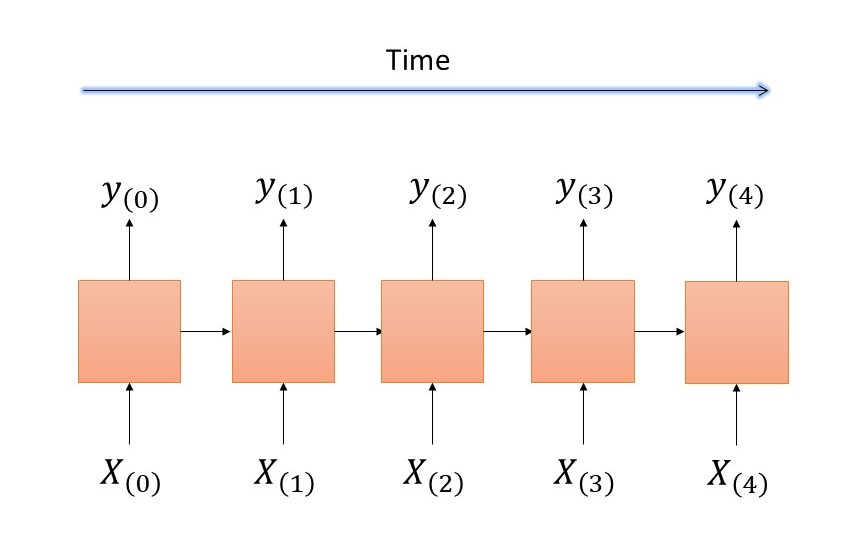

2. **Sequence-to-Vector network**

  When you feed a RNN a sequence of inputs and ignore all outputs except for the last one.

  For example you can use this type of network for outputing a sentiment score for a sequence of movie reviews.


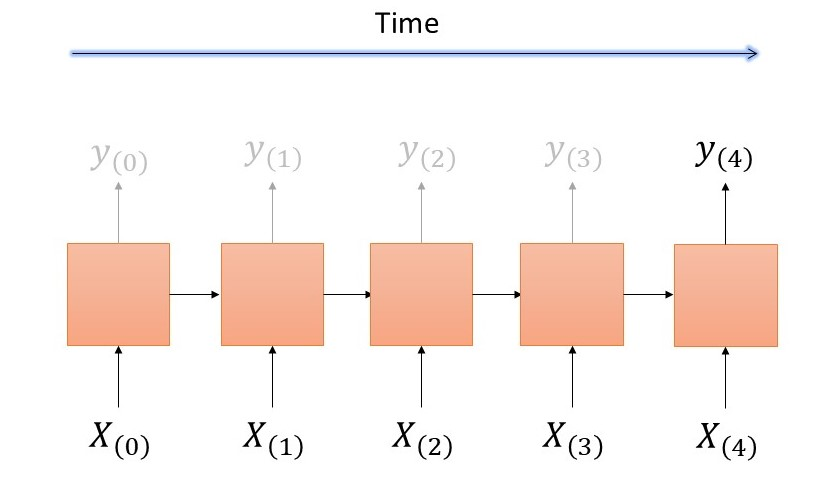

3. **Vector-to-Sequence network**

  When we feedd the RNN th same input vector over and over again at each time step and let it output a sequence.

  Like outputing captions for image.
  

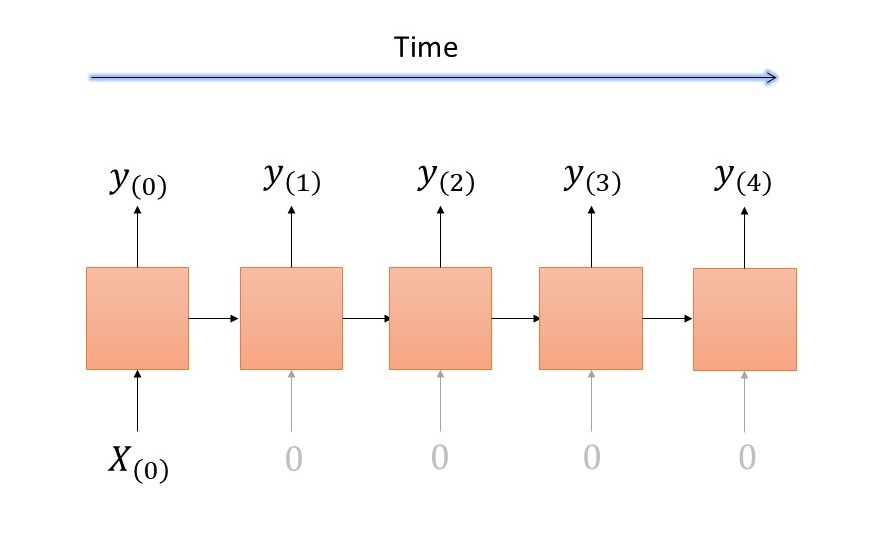

4. **Encoder-Decoder**

  You could have a sequence-to-vector network, called an *encoder*, followed by a vector-to-sequence network, called a *decoder*. This all set up is called Encoder-Decoder.

  This can be useful for translating a sentence (A sequence) from one language to another (another sequence).

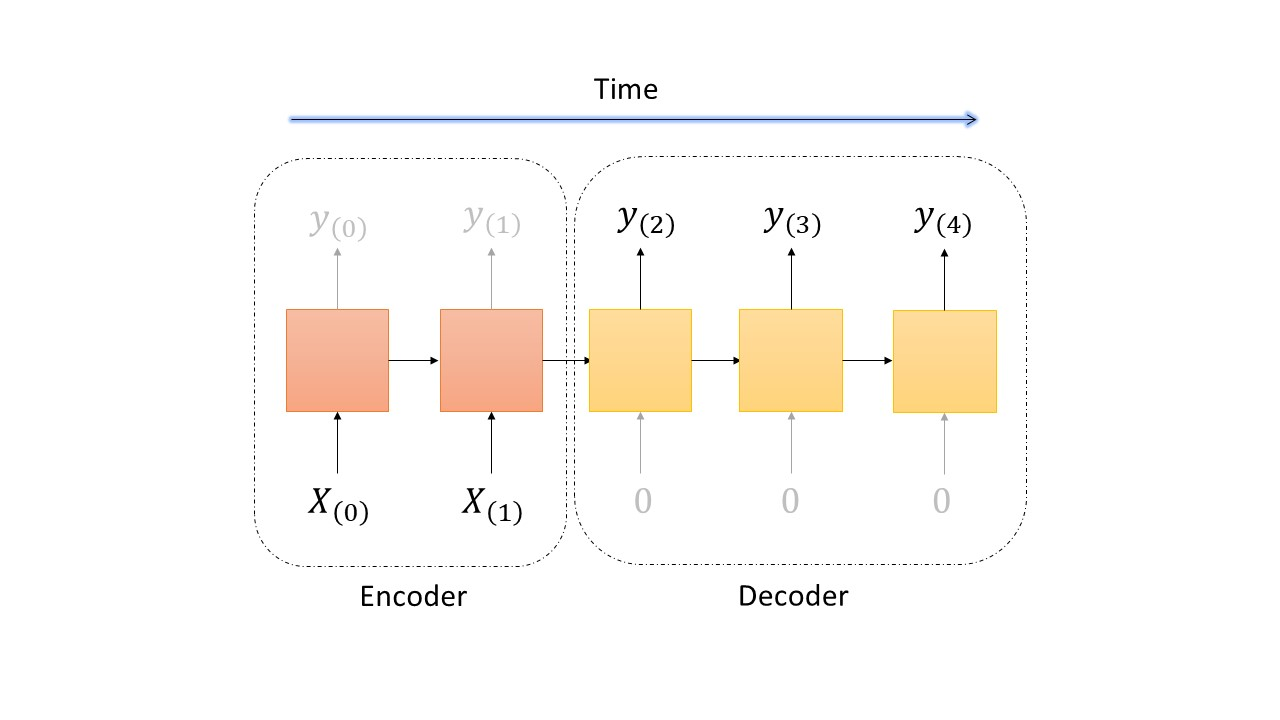

# Training RNNs
The trick is to unroll it through time and then simply use regular backpropagation. This strategy is called ***backpropagation through time*** (BPTT).
1. As usual forward pass through the unrolled network.
2. The output sequence is evaluated using a cost Function.$$C(Y_{(0)}, Y_{(1)}, ...,Y_{(T)}$$ (Where $T$ is the max time step). 
The cost may avoid some output, as in the case of sequence-to-vector network where only last output matters. 
3. The gradients of the cost function are then propogated backward through the unrolled network. 

  (The gradients flow backward through all the outputs used by the cost function)
4. Finally the model parameters are updated using the gradients computed during BPTT.



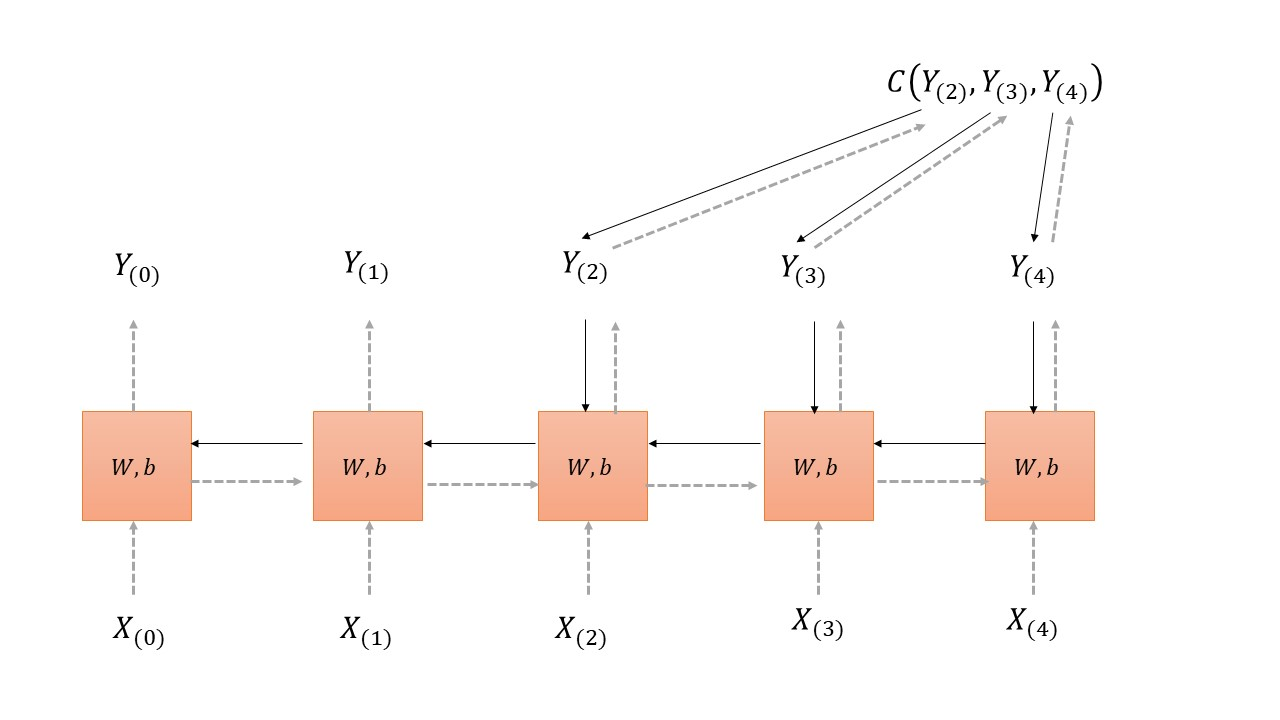

# Forecasting Time series
<mark>The data which has one or more values per time step is called *time series*.</mark>

- **Univariate time series**: single value per time step
- **multivariate time series**: multiple values per time step. 

When we want to <mark>predict future values, it is called *forecasting*.</mark>

<mark>When we want to predict (or rather "postdict") missing values from the past, it is called *imputation*.</mark>

Let's create a univariate time series, each 50 time steps long. Our goal will be to forecast the value at the next time step.



In [ ]:
def generate_time_series(batch_size, n_steps):
  """
  creates <batch_size> number of times time series
  each of being <n_steps> steps long

  Each series is the sum of two sine waves of fixed amplitudes
  but random frequencies and phase + noise

  returns: Numpy array of shape
           [batch_size, time_steps, 1]
  """
  freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
  time = np.linspace(0, 1, n_steps)
  series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))   #   wave 1
  series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
  series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
  return series[..., np.newaxis].astype(np.float32)

> 🔵 When dealing with time series, we usually represent the input with shape `[batch_size, time_steps, dimensionality]` where `dimensionality` is 
> - 1 for univariate time series
> - more for mullivariate time series.


In [ ]:
n_steps = 50
batch_size = 10000
series = generate_time_series(batch_size, n_steps+1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [ ]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

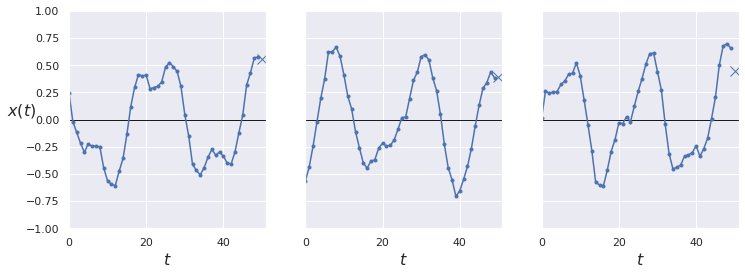

In [ ]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))

## Baseline Metrics
Creating baseline metrics let's use make comparison against the model we create, to know whether it's actually doing good or not then even in basic solutions possible.

**Naive forecasting**: Simply predicting the last value in each series.

In [ ]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.02091173

Another approach is to use fully connected network.

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

In [ ]:
model.compile(loss="mse",
              optimizer="adam")

history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 2/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 4/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 5/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 6/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 7/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0035
Epoch 9/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 10/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0033

In [ ]:
model.evaluate(X_test, y_test)

32/32 [==============================] - 0s 917us/step - loss: 0.0031


0.0030866500455886126

## Implementing a Simple RNN


In [ ]:
model = keras.models.Sequential([
  keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

We set the `input_shape` to be `[None, 1]` which means we don't need to specify the length of input, since recurrent neural network can process any number of time steps.

`SimpleRNN` uses hyperbolic activation function.

>🔵 Set `return_sequence=True` to return one output per time step instead of just last one.



In [ ]:
model.compile(loss="mse",
              optimizer="adam")

history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 8ms/step - loss: 0.3217 - val_loss: 0.2286
Epoch 2/20
219/219 [==============================] - 1s 7ms/step - loss: 0.1921 - val_loss: 0.1136
Epoch 3/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0939 - val_loss: 0.0546
Epoch 4/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0493 - val_loss: 0.0385
Epoch 5/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0371 - val_loss: 0.0338
Epoch 6/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0331 - val_loss: 0.0309
Epoch 7/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0309 - val_loss: 0.0285
Epoch 8/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0288 - val_loss: 0.0265
Epoch 9/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0268 - val_loss: 0.0246
Epoch 10/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0252 - val_loss: 0.0229

In [ ]:
model.evaluate(X_test, y_test)

32/32 [==============================] - 0s 2ms/step - loss: 0.0129


0.012863718904554844

The model does beat naive forecasting, but is unable to do so against simple linear regressor.

It's so 'cause a linear model has weight for each inputs (plus a bias) whereas in our simple RNN, there is just 3 parameters (one weight for input, one for the output and a bias term)

## Deep RNNs
<mark>Stacking mulitple layers of cells gives us *deep RNN*.</mark>



In [ ]:
model = keras.models.Sequential([
  keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
  keras.layers.SimpleRNN(20, return_sequences=True),
  keras.layers.SimpleRNN(1)
])

>🔴 Setting `return_sequences=True` for layer wil output 3D array (containing outputs for all the last time steps otherwise a 2D array (only the output of the last time step). 

In [ ]:
model = keras.models.Sequential([
  keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
  keras.layers.SimpleRNN(20),
  keras.layers.Dense(1)
])

In [ ]:
model.compile(loss="mse",
              optimizer="adam")

history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

model.evaluate(X_test, y_test)

Epoch 1/20
219/219 [==============================] - 5s 18ms/step - loss: 0.0991 - val_loss: 0.0056
Epoch 2/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0047 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 4/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 5/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 6/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0030 - val_loss: 0.0036
Epoch 8/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 9/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 10/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0030 - val_lo

0.0027085980400443077

Yup, this beats a linear regressor.

## Forecasting Several Time Steps Ahead
Let's train an RNN to predict all 10 next values at once. 

For that we first need to change the targets to be vectors  containing next 10 values:

In [ ]:
series = generate_time_series(10000, n_steps + 10)
X_train, y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, y_test = series[9000:, :n_steps], series[9000:, -10, 0]

In [ ]:
model = keras.models.Sequential([
  keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
  keras.layers.SimpleRNN(20),
  keras.layers.Dense(10)
])

In [ ]:
model.compile(loss="mse",
              optimizer="adam")

history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

model.evaluate(X_test, y_test)

Epoch 1/20
219/219 [==============================] - 5s 18ms/step - loss: 0.0769 - val_loss: 0.0255
Epoch 2/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0220 - val_loss: 0.0165
Epoch 3/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0156 - val_loss: 0.0148
Epoch 4/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0138 - val_loss: 0.0122
Epoch 5/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0128 - val_loss: 0.0118
Epoch 6/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0116 - val_loss: 0.0108
Epoch 7/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0112 - val_loss: 0.0111
Epoch 8/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0103 - val_loss: 0.0101
Epoch 9/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0112 - val_loss: 0.0108
Epoch 10/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0103 - val_lo

0.20472005009651184

This was sequence-to-vector model. 

By converting it to sequence to sequence model it performs even better.

We want to predicate next 10 values, to do that we need to set each target must be a sequence of the same length as the input sequence.

In [ ]:
Y = np.empty((10000, n_steps, 10)) # each target is a sequence of 10D vectors
for step_ahead in range(1, 10+1):
  Y[:, :, step_ahead - 1] = series[:, step_ahead:step_ahead + n_steps, 0]
y_train = Y[:7000]
y_valid = Y[7000:9000]
y_test = Y[9000:]

**To turn the model into a sequence-to-sequence model, we must set `return_sequence=True` in all recurrent layers and apply the output `Dense` layer at every time step. (using `TimeDistributed` layer)**. 




In [ ]:
model = keras.models.Sequential([
  keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
  keras.layers.SimpleRNN(20, return_sequences=True),
  keras.layers.TimeDistributed(keras.layers.Dense(10))
])

We will use a custom metric for evaluation, to only compute the MSE over the output at the last time step.

In [ ]:
def last_time_step_mse(y_true, y_pred):
  return keras.metrics.mean_squared_error(y_true[:, -1], y_pred[:, -1])

optimizer = keras.optimizers.Adam(lr=0.01)
model.compile(loss="mse",
              optimizer=optimizer, 
              metrics=[last_time_step_mse])

In [ ]:
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

model.evaluate(X_test, y_test)

Epoch 1/20
219/219 [==============================] - 6s 19ms/step - loss: 0.0707 - last_time_step_mse: 0.0608 - val_loss: 0.0421 - val_last_time_step_mse: 0.0304
Epoch 2/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0406 - last_time_step_mse: 0.0300 - val_loss: 0.0339 - val_last_time_step_mse: 0.0218
Epoch 3/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0349 - last_time_step_mse: 0.0243 - val_loss: 0.0307 - val_last_time_step_mse: 0.0184
Epoch 4/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0310 - last_time_step_mse: 0.0196 - val_loss: 0.0259 - val_last_time_step_mse: 0.0121
Epoch 5/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0268 - last_time_step_mse: 0.0131 - val_loss: 0.0270 - val_last_time_step_mse: 0.0126
Epoch 6/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0237 - last_time_step_mse: 0.0108 - val_loss: 0.0227 - val_last_time_step_mse: 0.0084
Epoch 7/20
219/219 [==

[0.019165974110364914, 0.005855688825249672]

# Handling Long Sequuences
To train an RNN on long sequences, we must run it over many time steps. This makes:
- training takes forever or may become unstable
- Doing so, it will gradually forget the first inputs in the sequence.

## Fighting the Unstable Gradients Problem
Many of the techniques we have discussed so far to eliminate this problem works with RNNs too. Except with the fast that nonsaturating activation function like ReLU may not help much; instead it may lead RNN to be even more unstable during training.

Also you cannot use Batch Normalization between time steps, but only between recurrent layers.
Although it was slightly better than nothing when applied between recurrent layer (i,e., vertically), but not within recurrent layer (i.e., horizontally).

***Layer Normalization***: works better with RNN, the idea is to instead of normalizing across the batch dimension (like in BN), <mark>normalizes across the feature dimension</mark>

- Computes the required statistics on the fly
- behaves the same way during training and testing
- doesn't uses exponential moving averages to estimate the feature statistics across all instances in the training set.

Let's use `tf.keras` to implement Layer Normalization withing a simple memory cell.

1. Define a custom memory cell

  Same like a normal layer, except that the `call()` method accepts two arguments: 
  1. the `inputs` at the current time step and 
  2. the hidden `states` from the previous time step.

2. A cell must also have a `state_size` attribute and an `output_size` attribute. (For simple RNN both equal to no of units)


In [2]:
class LNSimpleRNNCell(keras.layers.Layer):
  """
  Behaves like SimpleRNNCell, but
  also applies Layer Normalization at each step.
  """
  def __init__(self, units, activation="tanh", **kwargs):
    super().__init__(**kwargs)
    self.state_size = units
    self.output_size = units
    self.simple_rnn_cell = keras.layers.SimpleRNNCell(units, 
                                                      activation=None)
    self.layer_norm = keras.layers.LayerNormalization()
    self.activation = keras.activations.get(activation)
  def call(self, inputs, states):
    outputs, new_states = self.simple_rnn_cell(inputs, states)
    norm_outputs = self.activation(self.layer_norm(outputs))
    return norm_outputs, [norm_outputs]

Let's use this custom cell:


In [5]:
model = keras.models.Sequential([
  keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True, input_shape=(None, 1)),
  keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
  keras.layers.TimeDistributed(keras.layers.Dense(10))
])

All cells provided by Keras have:
- `dropout` hyperparameter that defines the dropout rate to apply to the inputs (at each time step).
- `recurrent_dropout` hyperparameter that defines the dropout rate for the hidden state (also at each time step).



## Tackling the Short-Term Memory Problem
Due to transformations that the data goes through when traversing an RNN, some infomration is lost at each time step. After a while, the RNN's state contains virtually no trace of the first inputs.

To tackle this various cells have been introduced, which so much so are proven that regular cells are rarely used anymore.



### LSTM cells
***Long Short-Term Memory*** (LSTM) cells was proposed in 1997 by Sepp Hichreiter and Jurgen Schmidhuber and gradually improved.
- converge faster
- detect long term dependencies 

It's state is split into two vectors:<mark> $h_{(t)}$ and $c_{(t)}$ ("c" stands for "cell"). We can think of $h_{(t)}$ as the short term state and $c_{(t)}$ as the long term state.</mark>

In [6]:
model = keras.models.Sequential([
  keras.layers.LSTM(20, return_sequences=True, input_shape=(None, 1)),
  keras.layers.LSTM(20, return_sequences=True),
  keras.layers.TimeDistributed(keras.layers.Dense(10))
])

Alternatively, we can use general-pupose `RNN` layer, and pass it `LSTMCell` as an argument:

(Use it only when you have custom defined cells, `LSTM` layer performs better on GPUs)

In [10]:
model = keras.models.Sequential([
  keras.layers.RNN(keras.layers.LSTMCell(20), return_sequences=True, input_shape=(None, 1)),
  keras.layers.RNN(keras.layers.LSTMCell(20), return_sequences=True),
  keras.layers.TimeDistributed(keras.layers.Dense(10))
])